# Исследование надёжности заёмщиков

#### Описание задачи 
Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

<a name='back'></a>
## Навигация по содержанию
- [Библиотеки](#libraries)  
- [1. Знакомство с данными ](#dataintro)  
- [2. Предобработка данных](#datacleaning)      
    -    [Работа с дубликатами](#douplicates)  
    -    [Обработка пропусков и ошибок](#nans) 
    -    [Замена типов данных](#datatypes)  
- [3. Лемматизация и категоризация данных](#lemmas)
- [4. Исследовательский анализ данных](#analysis)
- [5. Общий вывод](#conclusion)

### Библиотеки <a name="libraries"></a>

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd 
from pymystem3 import Mystem 
m = Mystem()
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

In [2]:
import warnings
warnings.filterwarnings('ignore') 

## Шаг 1. Знакомство с данными
<a name="dataintro"></a>
#### [Вернуться к оглавлению](#back) 

#### Описание данных
Таблица **loans_project1** - статистика о платёжеспособности клиентов - содержит следующие данные о заемщиках:  
`children` — количество детей в семье  
`days_employed` — общий трудовой стаж в днях  
`dob_years` — возраст клиента в годах  
`education` — уровень образования клиента  
`education_id` — идентификатор уровня образования  
`family_status` — семейное положение  
`family_status_id` — идентификатор семейного положения  
`gender` — пол клиента  
`income_type` — тип занятости  
`debt` — имел ли задолженность по возврату кредитов  
`total_income` — ежемесячный доход  
`purpose` — цель получения кредита  

In [3]:
# читаем файл:
raw_data = pd.read_csv('datasets/loans_project1', index_col=0)
# знакомимся с содержанием таблицы по первым 10 строкам
raw_data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Сразу удалим колонки, информация в которых не значима для данного иследования.  
Оставим в таблице только следующие столбцы:  
'children', 'family_status', 'family_status_id', 'debt', 'total_income', 'purpose'


In [4]:
# список столбцов, которые мы удаляем:
columns_to_delete = ['days_employed', 'dob_years', 'education', 'education_id', 'family_status_id', 'gender'] 
# удаление этих столбцов с помощью функции drop():
data = raw_data.drop(columns_to_delete, axis=1) 
data.head() # проверяем, как выглядит таблица после удаления не релевантных для данного исследования столбцов

,children,family_status,income_type,debt,total_income,purpose
0,1,женат / замужем,сотрудник,0,253875.639453,покупка жилья
1,1,женат / замужем,сотрудник,0,112080.014102,приобретение автомобиля
2,0,женат / замужем,сотрудник,0,145885.952297,покупка жилья
3,3,женат / замужем,сотрудник,0,267628.550329,дополнительное образование
4,0,гражданский брак,пенсионер,0,158616.077870,сыграть свадьбу


In [5]:
# просматриваем форму таблицы 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21525 entries, 0 to 21524
Data columns (total 6 columns):
children         21525 non-null int64
family_status    21525 non-null object
income_type      21525 non-null object
debt             21525 non-null int64
total_income     19351 non-null float64
purpose          21525 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 1.1+ MB


In [6]:
# последовательно рассматриваем уникальные значения в каждом из оставленных столбцов 
# с помощью функции value_counts() для дискретных значений

columns = ['children', 'family_status', 'income_type', 'debt','purpose'] # список столбцов с дискретными признаками

for column in columns:
    print('Значения колонки', column)
    print(data[column].value_counts())
    print('----------------------------')
    print()

Значения колонки children
 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64
----------------------------

Значения колонки family_status
женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64
----------------------------

Значения колонки income_type
сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
в декрете              1
студент                1
Name: income_type, dtype: int64
----------------------------

Значения колонки debt
0    19784
1     1741
Name: debt, dtype: int64
----------------------------

Значения колонки purpose
свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции

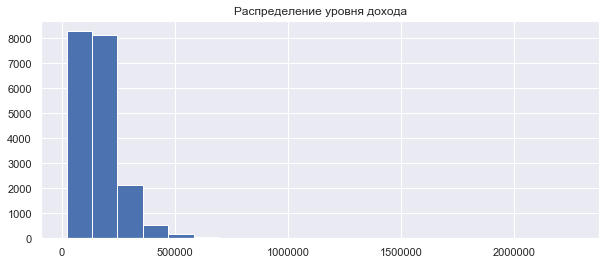

In [7]:
# смотрим распределение непрерывных величин на гистограмме
data['total_income'].hist(bins=20, figsize=(10,4))
plt.title('Распределение уровня дохода');

### Вывод
Важные для данного исследования столбцы: `'children', 'family_status', 'family_status_id', 'debt', 'total_income', 'purpose'`. Остальные столбцы исходной таблицы удалены, так как они не несут полезной для исследования информации.

Типы данных в таблице не помешают нам проводить операции, но для оптимизации переведем столбцы `children, family_status, income_type, debt` в тип category.

В таблице найден ряд данных, нуждающихся в доработке.  

Так, в столбце `children` обноружены заведомо ошибочные данные: 76 человек имеют *20* детей, а 47 - *-1*. Необходимо запросить информацию о том, что могут обозначать эти показатели в данном столбце.  
Предположение: причина таких данных в опечатке, и там, где должно было быть "2" стоит "20", а вместо "1" - "-1". То есть ошибки случайны и определены человеческим фактором. Однако, мы не можем подтвердить данную гипотезу.  
Так как выяснить корректные значения не удается, строки с *-1* или *20* в столбце `children` нужно удалить.

Также необходимо обработать пропуски в столбце `total_income`.



## Шаг 2. Предобработка данных
<a name="datacleaning"></a>
#### [Вернуться к оглавлению](#back) 

### Обработка дубликатов
<a name="douplicates"></a>

In [8]:
# Проверка таблицы на дубликаты:
duplicates_number = data.duplicated().sum()
if duplicates_number == 0:
    print('В таблице нет дубликатов.')
else:
    print('В таблице {:.0f} дубликатов'.format(duplicates_number))

В таблице 1291 дубликатов


Так как в исходной таблице не обозначены id клиентов, есть риск потерять значимые данные при удалении полностью дублирующихся строк. Необходимо обратиться к предоставившим данные коллегам и запросить разъяснения по поводу индивидуальных идентификаторов клиентов в таблице.

До этого предполагаем, что каждая из строк в исходной таблице содержит данные о разных клиентах. Значит, **принимаем, что в таблице нет дублей.**

В случае возврата дополнительных данных с id клиентов, чьи данные содержит таблица, перед этапом удаления нерелевантных для исследования столбцов проведем следующие операции:
1. с помощью функций duplicated() и sum() вычислим количество дублирующихся строк в таблице raw_data,
2. при обнаружении дубликатов удалим эти строки с помощью функции drop_duplicates(),
3. проверим результат повторным вызовом функций duplicated() и sum().

### Обработка пропусков и ошибок 
<a name="nans"></a>

In [9]:
# Оставляем в таблице строки, где в столбце'children' значения не "20" и не "-1"
data = data[(data['children'] != 20) & (data['children'] != (-1))]
data['children'].value_counts() # проверяем уникальные значения столбца 'children' после изменений

0    14149
1     4818
2     2055
3      330
4       41
5        9
Name: children, dtype: int64

In [10]:
# проверяем строки на пропуски с помощью isnull()
data.isnull().sum()

children            0
family_status       0
income_type         0
debt                0
total_income     2162
purpose             0
dtype: int64

Заменим пропуски в столбце `total_income` на медиану в соответствии со значением в столбце `income_type`.

In [11]:
# Выяисним медианный доход по income_type
data.groupby('income_type')['total_income'].median()

income_type
безработный        131339.751676
в декрете           53829.130729
госслужащий        150420.150276
компаньон          172517.418907
пенсионер          118480.837408
предприниматель    499163.144947
сотрудник          142587.588976
студент             98201.625314
Name: total_income, dtype: float64

In [12]:
# запишем эти данные в таблицу median_income и добавим в таблицу data 
median_income = data.groupby('income_type')['total_income'].median().reset_index()
median_income.columns = ['income_type','median_income']
data = data.merge(median_income, on='income_type')
data.head()

,children,family_status,income_type,debt,total_income,purpose,median_income
0,1,женат / замужем,сотрудник,0,253875.639453,покупка жилья,142587.588976
1,1,женат / замужем,сотрудник,0,112080.014102,приобретение автомобиля,142587.588976
2,0,женат / замужем,сотрудник,0,145885.952297,покупка жилья,142587.588976
3,3,женат / замужем,сотрудник,0,267628.550329,дополнительное образование,142587.588976
4,0,женат / замужем,сотрудник,0,135823.934197,образование,142587.588976


In [13]:
# проверяем, есть ли в столбце 'total_income' нули, чтобы исключить удаление информации о клиентах, доход которых равен нулю
zero_income = data[data['total_income'] == 0]['total_income'].count()

if zero_income == 0:
    print('В колонке `total_income` нет нулей, можно заменять ими пропуски.')
else:
    print('Нельзя заменять пропуски нулями')

В колонке `total_income` нет нулей, можно заменять ими пропуски.


In [14]:
# заменяем пропуски в столбце total_income на 0
data['total_income'] = data['total_income'].fillna(0)

In [15]:
# напишем и применим функцию, которая заменяет пропус в total_income на соответствующее значение в median_income
def nan_is_median(row):
    total_income = row['total_income']
    median_income = row['median_income']
    if total_income==0:
        total_income=median_income
        return total_income
    else:
        total_income=total_income
        return total_income
    
# заменим пропуски в total_income в соответствии с медианой по income_type
data['total_income'] = data.apply(nan_is_median, axis=1)

In [16]:
# удалим столбцы median_income и  income_type
data = data.drop(['income_type','median_income'], axis=1)

data.head()

,children,family_status,debt,total_income,purpose
0,1,женат / замужем,0,253875.639453,покупка жилья
1,1,женат / замужем,0,112080.014102,приобретение автомобиля
2,0,женат / замужем,0,145885.952297,покупка жилья
3,3,женат / замужем,0,267628.550329,дополнительное образование
4,0,женат / замужем,0,135823.934197,образование


### Замена типов данных
<a name="datetypes"></a>

In [17]:
# заменим тип данных в колонках 'children', 'family_status', 'debt' на category 
categories = ['children', 'family_status', 'debt']
for category in categories:
    data[category] = data[category].astype('category')

In [18]:
data.info() # проверям результат

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21402 entries, 0 to 21401
Data columns (total 5 columns):
children         21402 non-null category
family_status    21402 non-null category
debt             21402 non-null category
total_income     21402 non-null float64
purpose          21402 non-null object
dtypes: category(3), float64(1), object(1)
memory usage: 564.8+ KB


### Вывод
Мы приняли, что в таблице нет дубликатов.

Информация о годовом доходе клиентов была пропущена в 2162 строках из 21402. 
Вероятная причина - человеческая ошибка при внесении данных в таблицу либо нежелание/невозможность клиентов предоставить эту информацию.
Так как в значениях столбца есть артефакты, пропуски в `total_income` заменены на медиану по `incom_type`.

Произведена замена типов данных в колонках `'children', 'family_status', 'debt'` на category.  
В остальных столбцах замена не требуется.

## Шаг 3. Лемматизация и категоризация 
<a name="lemmas"></a>
#### [Вернуться к оглавлению](#back) 

- Разделим клиентов на категории по цели получения кредита. Для этого применим лемматизацию;
- Также разделим клиентов на категории по уровню дохода.

### Лемматизация


Выделим из значений колонки `purpose` основные категории среди целей кредита.

In [19]:
purposes = data['purpose'].unique() #сохраняем уникальные значения столбца 'purpose' в переменную
purposes = ' '.join(purposes) #объединяем эти значения в строку
lemmas = m.lemmatize(purposes) #лемматизируем значения столбца с целями получения кредита

from collections import Counter # импортируем Counter для подсчета количества часто встречающихся слов в 'purpose'
print(Counter(lemmas)) # вызываем Counter 
print()
print(data['purpose'].unique()) # печатаем список уникальных значений 'purpose' 
# Смотря на оба списка, оцениваем, какие слова из часто встречающихся можно отнести к одной категории

Counter({' ': 96, 'покупка': 10, 'недвижимость': 10, 'автомобиль': 9, 'образование': 9, 'жилье': 7, 'с': 5, 'на': 4, 'свой': 4, 'операция': 4, 'свадьба': 3, 'строительство': 3, 'получение': 3, 'высокий': 3, 'дополнительный': 2, 'для': 2, 'коммерческий': 2, 'подержать': 2, 'заниматься': 2, 'сделка': 2, 'жилой': 2, 'приобретение': 1, 'проведение': 1, 'семья': 1, 'собственный': 1, 'сыграть': 1, 'со': 1, 'профильный': 1, 'сдача': 1, 'ремонт': 1, '\n': 1})

['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 'образование' 'на проведение свадьбы' 'покупка жилья для семьи'
 'покупка коммерческой недвижимости'
 'строительство собственной недвижимости' 'недвижимость'
 'строительство недвижимости' 'на покупку своего автомобиля'
 'на покупку подержанного автомобиля' 'сыграть свадьбу' 'жилье'
 'операции со своей недвижимостью' 'автомобили' 'получение образования'
 'заняться образованием' 'автомобиль' 'свадьба'
 'получение дополнительного образования' 'покупка недвижимости'
 'о

### Вывод

Цели получения кредита в данной таблице разделяются на 4 категории: 
+ недвижимость (объединяет цели, в леммах которых есть фразы недвижимость + жилье + строительство + ремонт), 
+ автомобиль, 
+ образование, 
+ свадьба.

### Категоризация данных

In [20]:
# Разделим цели получения кредита на категории, которые мы определили в шаге "Лемматизация"

# создаем столбец для категорий целей
data['purpose_category'] = ' '

In [21]:
# пишем функцию, которая заменяет строку на одну из категорий в соответствии с леммой цели
def categorizing_purpose(purposes):
        lemmas = m.lemmatize(purposes) #лемматизируем исходную строку
        for name in lemmas: #если среди строки есть ключевое слово, производим замену на соответсвующую категорию
            if name == 'жилье':
                purposes = 'недвижимость'    
                return purposes
            elif name == 'недвижимость':
                purposes = 'недвижимость'    
                return purposes
            elif name == 'строительство':
                purposes = 'недвижимость'    
                return purposes
            elif name == 'ремонт':
                purposes = 'недвижимость'    
                return purposes
            
            elif name == 'автомобиль':
                purposes = 'автомобиль'
                return purposes

            elif name == 'образование':
                purposes = 'образование'
                return purposes
            
            elif name == 'свадьба':
                purposes = 'свадьба'
                return purposes

data['purpose_category'] = data['purpose'].apply(categorizing_purpose) # применяем эту функцию к кажой строке таблицы
data.head() # смотрим на результат в первых пяти строках

,children,family_status,debt,total_income,purpose,purpose_category
0,1,женат / замужем,0,253875.639453,покупка жилья,недвижимость
1,1,женат / замужем,0,112080.014102,приобретение автомобиля,автомобиль
2,0,женат / замужем,0,145885.952297,покупка жилья,недвижимость
3,3,женат / замужем,0,267628.550329,дополнительное образование,образование
4,0,женат / замужем,0,135823.934197,образование,образование


In [22]:
# Разделим клиентов на имеющих и не имеющих детей
data['children_id'] = ' ' # добавим столбец, идентифицирующий наличие детей
# пишем функцию для обозначения наличия у клиента детей по их (детей) количеству
def children_yesno(row):  
    children = row['children']
    children_id = row['children_id']
    if children == 0:
        return 'детей нет'
    return 'дети есть'

data['children_id'] = data.apply(children_yesno, axis=1) # результаты выносим в столбец 'children_id'
data.head()

,children,family_status,debt,total_income,purpose,purpose_category,children_id
0,1,женат / замужем,0,253875.639453,покупка жилья,недвижимость,дети есть
1,1,женат / замужем,0,112080.014102,приобретение автомобиля,автомобиль,дети есть
2,0,женат / замужем,0,145885.952297,покупка жилья,недвижимость,детей нет
3,3,женат / замужем,0,267628.550329,дополнительное образование,образование,дети есть
4,0,женат / замужем,0,135823.934197,образование,образование,детей нет


In [23]:
# Разделим клиентов на имеющих и не имеющих задолженности
data['debt_id'] = ' ' # добавим столбец, идентифицирующий наличие задолженностей
# пишем функцию для обозначения наличия у клиента задолженностей
def debt_id(row):
    debt = row['debt']
    if debt==0:
        return 'Нет задолженностей'
    else:
        return 'Есть задолженности'
    
data['debt_id'] = data.apply(debt_id, axis=1) # результаты выносим в столбец 'debt_id'
data.head()

,children,family_status,debt,total_income,purpose,purpose_category,children_id,debt_id
0,1,женат / замужем,0,253875.639453,покупка жилья,недвижимость,дети есть,Нет задолженностей
1,1,женат / замужем,0,112080.014102,приобретение автомобиля,автомобиль,дети есть,Нет задолженностей
2,0,женат / замужем,0,145885.952297,покупка жилья,недвижимость,детей нет,Нет задолженностей
3,3,женат / замужем,0,267628.550329,дополнительное образование,образование,дети есть,Нет задолженностей
4,0,женат / замужем,0,135823.934197,образование,образование,детей нет,Нет задолженностей


In [24]:
# Разделим клиентов по уровню дохода, используя квартили

data['income_level'] = pd.qcut(data['total_income'], 4, 
                               ['Низкий уровень дохода','Ниже среднего','Выше среднего','Высокий уровень дохода'])
data.head()

,children,family_status,debt,total_income,purpose,purpose_category,children_id,debt_id,income_level
0,1,женат / замужем,0,253875.639453,покупка жилья,недвижимость,дети есть,Нет задолженностей,Высокий уровень дохода
1,1,женат / замужем,0,112080.014102,приобретение автомобиля,автомобиль,дети есть,Нет задолженностей,Ниже среднего
2,0,женат / замужем,0,145885.952297,покупка жилья,недвижимость,детей нет,Нет задолженностей,Выше среднего
3,3,женат / замужем,0,267628.550329,дополнительное образование,образование,дети есть,Нет задолженностей,Высокий уровень дохода
4,0,женат / замужем,0,135823.934197,образование,образование,детей нет,Нет задолженностей,Ниже среднего


### Вывод

Для анализа зависимостей характеристик клиента мы создали определенные категории:
* **children_id** для анализа зависимость между наличием детей и возвратом кредита в срок
* **income_level** для рассмотрения зависимостей между **уровенем дохода** и возвратом кредита в срок
* **purpose_category** для исследования связей между **целями получения кредита** и его возвратом в срок
* **debt_id** для более наглядной иллюстрации в сводных таблицах

## Шаг 4. Анализ данных

<a name="analysis"></a>
#### [Вернуться к оглавлению](#back) 

Ответим на вопросы:  
- Есть ли зависимость между наличием детей и возвратом кредита в срок?
- Есть ли зависимость между семейным положением и возвратом кредита в срок?
- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
- Как разные цели кредита влияют на его возврат в срок?

### Зависимость между наличием детей и возвратом кредита в срок

In [25]:
# Рассмотрим как меняется вероятность задолженности по кредиту от наличия детей
children_debt_pivot = data.pivot_table(index='children_id', columns='debt_id', values='debt', aggfunc='count')
children_debt_pivot['share'] = children_debt_pivot['Есть задолженности'] / \
                                (children_debt_pivot['Есть задолженности'] + children_debt_pivot['Нет задолженностей'])
children_debt_pivot['share'] = children_debt_pivot['share'].map('{:,.2%}'.format)
children_debt_pivot

debt_id,Есть задолженности,Нет задолженностей,share
children_id,,,
детей нет,1063,13086,7.51%
дети есть,669,6584,9.22%


Среди клиентов, имеющих детей, 9.22% имеют задолженность по возврату кредитов, 90.78% - не имеют.  
Среди клиентов, не имеющих детей, 7.51% имеют задолженность по возврату кредитов, 92.49% - не имеют.

In [26]:
# Теперь рассмотрим, как количество детей влияет на эту зависимость.

# Cоздаем сводную таблицу, отображающую зависимость количества детей и наличия просрочек по оплате кредита
children_debt_pivot = data.pivot_table(index='children',
                                      columns='debt_id', values='debt', aggfunc='count'
                                      ).fillna(0)
# расчитываем отношение задолжников в каждой группе с количеством человек в группе
children_debt_pivot['debt_probability']= children_debt_pivot['Есть задолженности'] / \
                                        (children_debt_pivot['Есть задолженности'] + children_debt_pivot['Нет задолженностей']) 
# переводим это отношение в проценты
children_debt_pivot['debt_probability'] = children_debt_pivot['debt_probability'].map('{:,.2%}'.format)

# печатаем таблицу
children_debt_pivot.drop(['Есть задолженности', 'Нет задолженностей'], axis=1)

debt_id,debt_probability
children,
0,7.51%
1,9.22%
2,9.44%
3,8.18%
4,9.76%
5,0.00%


### Вывод

Среди клиентов, **имеющих детей**, *9.22%* имеют задолженность по возврату кредитов, *90.78%* - не имеют.  
Среди клиентов, **не имеющих детей**, *7.51%* имеют задолженность по возврату кредитов, *92.49%* - не имеют.

Таким образом, ***клиенты без детей имеют больше шансов оплачивать кредит без задолженностей.***

***Разница в вероятности задолженностей в зависимости от количества детей у клиента невелика*** (в семьях с пятью детьми наблюдается идеальная кредитная история, в остальных случаях варьируется *от 8.18%* в семьях с тремя детьми до *9.76%* в семьях с четыремя детьми). Однако стоит учесть, что в данной таблице количество клиентов тем меньше, чем больше у них детей (например, семей с пятью детьми всего 9, в то время как клиентов с одним ребенком - 14149), а значит точность вероятности задолженности снижается с увеличением количества детей у клиента. 

### Зависимость между семейным положением и возвратом кредита в срок

In [27]:
# Рассмотрим как меняется вероятность допустить задолженность по кредиту от семейного положения.
# создаем сводную таблицу, отображающую зависимость семейного положения и наличия просрочек по оплате кредита
family_debt_pivot = data.pivot_table(index=['family_status'], columns='debt_id', values='debt', aggfunc='count')

# расчитываем отношение задолжников в каждой группе с количеством человек в группе
family_debt_pivot['Вероятность задолженности']= family_debt_pivot['Есть задолженности'] / (family_debt_pivot['Есть задолженности'] + family_debt_pivot['Нет задолженностей']) 
# переводим это отношение в проценты
family_debt_pivot['Вероятность задолженности'] = family_debt_pivot['Вероятность задолженности'].map('{:,.2%}'.format)
# сортируем таблицу по возрастанию вероятности допущения задолженности
family_debt_pivot = family_debt_pivot.sort_values(by = ['Вероятность задолженности'], ascending = True)

# печатаем таблицу
family_debt_pivot

debt_id,Есть задолженности,Нет задолженностей,Вероятность задолженности
family_status,,,
вдовец / вдова,63,889,6.62%
в разводе,84,1105,7.06%
женат / замужем,927,11375,7.54%
гражданский брак,385,3775,9.25%
Не женат / не замужем,273,2526,9.75%


### Вывод

По результатам анализа самыми добросовестными плательщиками являются **вдовцы и вдовы**, среди них лишь *6.62%* имели задолженности по кредитам. Клиенты же, **не состоящие в браке**, не оплачивают кредит вовремя *на 47% чаще*.

Состоящие в гражданском браке клиенты также находятся в высокой зоне риска иметь кредитные задолженности.

Примечательно, что ***те, кто не состояли в официальном браке, с большей вероятностью будут иметь просрочки по кредитным платежам.***

### Зависимость между уровнем дохода и возвратом кредита в срок

In [28]:
# определим диапазоны уровней дохода с помощью квартилей:
data['total_income'].describe()

count    2.140200e+04
mean     1.652504e+05
std      9.817000e+04
min      2.066726e+04
25%      1.077163e+05
50%      1.425876e+05
75%      1.956010e+05
max      2.265604e+06
Name: total_income, dtype: float64

In [29]:
# Рассмотрим как меняется вероятность допустить задолженность по кредиту от уровня дохода
# создаем сводную таблицу, отображающую зависимость уровня дохода и наличия просрочек по оплате кредита
income_debt_pivot = data.pivot_table(index=['income_level'], columns='debt_id', values='debt', aggfunc='count')

# расчитываем отношение задолжников в каждой группе с количеством человек в группе
income_debt_pivot['Вероятность задолженности']= income_debt_pivot['Есть задолженности'] / (income_debt_pivot['Есть задолженности'] + income_debt_pivot['Нет задолженностей']) 
# переводим это отношение в проценты
income_debt_pivot['Вероятность задолженности'] = income_debt_pivot['Вероятность задолженности'].map('{:,.2%}'.format)
# сортируем таблицу по возрастанию вероятности допущения задолженности
income_debt_pivot = income_debt_pivot.sort_values(by = ['Вероятность задолженности'], ascending = False)

# печатаем таблицу
income_debt_pivot

debt_id,Есть задолженности,Нет задолженностей,Вероятность задолженности
income_level,,,
Ниже среднего,480,5014,8.74%
Выше среднего,441,4765,8.47%
Низкий уровень дохода,427,4924,7.98%
Высокий уровень дохода,384,4967,7.18%


### Вывод

По итогам исследования разница в вероятности невозврата кредита в срок среди разных груп дохода варьируются не сильно - в диапазоне *от 7.17% до 8.85%*.

Разделив клиентов на 4 группы по уровню дохода, выводим следующую закономерность.  
Выше всего риск допустить задолженность по оплате кредита у клиентов **с уровнем дохода выше среднего** (145,020-195,572) - *8.85%*.  
Чуть меньше он у клиентов - всего на *0.41%* - с уровнем дохода **ниже среднего**.  
Самые добросовестные плательщики - клиенты с **высоким (от 195,572) уровнем дохода**. Задолженности в этой группе допускают *7.18%*.  

Учитывая, что вероятность допущения задолженности не коррелируется с повышением/понижением уровня дохода, можем сделать вывод, что ***зависимости между уровнем дохода и возвратом кредита в срок нет***.

### Влияние целей кредита на его возврат в срок

In [30]:
# смотрим, сколько заявок на кредит подано по каждой из категорий:
data['purpose_category'].value_counts()

недвижимость    10780
автомобиль       4288
образование      3997
свадьба          2337
Name: purpose_category, dtype: int64

In [31]:
# Рассмотрим как меняется вероятность допустить задолженность по кредиту от целей получения кредита
# создаем сводную таблицу, отображающую зависимость целей получния кредита и наличия просрочек по оплате кредита
purpose_debt_pivot = data.pivot_table(index=['purpose_category'], columns='debt_id', values='debt', aggfunc='count')

# расчитываем отношение задолжников в каждой группе с количеством человек в группе
purpose_debt_pivot['Вероятность задолженности']= purpose_debt_pivot['Есть задолженности'] / (purpose_debt_pivot['Есть задолженности'] + purpose_debt_pivot['Нет задолженностей']) 
# переводим это отношение в проценты
purpose_debt_pivot['Вероятность задолженности'] = purpose_debt_pivot['Вероятность задолженности'].map('{:,.2%}'.format)
# сортируем таблицу по возрастанию вероятности допущения задолженности
purpose_debt_pivot = purpose_debt_pivot.sort_values(by = ['Вероятность задолженности'], ascending = False)

# печатаем таблицу
purpose_debt_pivot

debt_id,Есть задолженности,Нет задолженностей,Вероятность задолженности
purpose_category,,,
автомобиль,400,3888,9.33%
образование,369,3628,9.23%
свадьба,183,2154,7.83%
недвижимость,780,10000,7.24%


### Вывод

В самой популярной категории, **недвижимости**, меньше всего допускают просрочки по оплате кредита - в *7.24%* случаев.  
Разница между вероятностью допустить задолженности в категориях **"автомобиль"** и **"образование"** составляет меньше процента (*чуть более 9%*), как и между категориями **"свадьба"** и **"недвижимость"** (*7-8%*).
Таким образом, можно заключить, что ***при оплате кредита с целями приобритения недвижимости и празднованием свадьбы кредит возвращают в срок чаще***, чем с целями получить образование и приобрести автомобиль.

## Шаг 5. Общий вывод
<a name='conclusion'></a>
#### [Вернуться к оглавлению](#back) 

По результатам проделанного анализа выделяем следующие закономерности:
+ Зависимость между наличием детей и возвратом кредита в срок есть, клиенты без детей чаще погашают кредит в срок.  
+ Зависимость между семейным положением и возвратом кредита в срок есть. Те, кто не состояли в официальном браке (находящиеся в гражданском браке или одинокие), с большей вероятностью будут иметь просрочки по кредитным платежам.
+ Зависимости между уровнем дохода и возвратом кредита в срок нет.
+ Кредиты на недвижимость и свадьбу чаще погашают в срок, чем кредиты на автомобиль или образование.